## Train a conv layer on negative regions of the bigwig to see if it learns the bias motif

In [1]:
import keras
import tensorflow as tf
import pyfaidx
import math
import pandas as pd
import tqdm
import numpy as np
import pyBigWig
import scipy
import sys
import os
from keras.utils import CustomObjectScope
from modisco.visualization import viz_sequence
import keras.backend as K
import matplotlib.pyplot as plt

Using TensorFlow backend.


Edit the below cell to inputs of interest and run the notebook

In [20]:
sys.path.append("/srv/scratch/anusri/chrombpnet_paper/src/training/utils/") 
from losses import MultichannelMultinomialNLL, multinomial_nll
os.environ["CUDA_VISIBLE_DEVICES"]="0"
hg38 = pyfaidx.Fasta('/mnt/data/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta')
bw = pyBigWig.open("/srv/scratch/anusri/chrombpnet_paper/results/chrombpnet/ATAC_PE/GM12878/data/shifted.sorted.bam.chrombpnet.unstranded.bw") # +4/-5 shifted
gc_neg_peaks =  pd.read_csv("/srv/scratch/anusri/chrombpnet_paper/results/chrombpnet/ATAC_PE/GM12878/negatives_data/negatives.bed", # these are non-peaks for fibroblast scATAC pseudo-bulk
                           sep='\t',
                           names=["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"])
print(gc_neg_peaks.shape)
gc_neg_peaks["summit"] = (gc_neg_peaks["start"] + gc_neg_peaks["end"]) // 2
gc_neg_peaks.head()

(189914, 10)


,chr,start,end,1,2,3,4,5,6,summit
0,chr1,76592500,76594614,0.38,NaN,NaN,NaN,NaN,NaN,76593557
1,chr1,162533550,162535664,0.46,NaN,NaN,NaN,NaN,NaN,162534607
2,chr1,175032450,175034564,0.45,NaN,NaN,NaN,NaN,NaN,175033507
3,chr1,151808900,151811014,0.46,NaN,NaN,NaN,NaN,NaN,151809957
4,chr1,167826000,167828114,0.45,NaN,NaN,NaN,NaN,NaN,167827057


In [21]:
from importlib import reload
import one_hot

In [22]:
gc_neg_peaks = gc_neg_peaks.sample(n=25000, replace=True, random_state=1)
print(gc_neg_peaks.shape)

(25000, 10)


In [23]:
train_peaks = gc_neg_peaks[(gc_neg_peaks["chr"]!="chr1")&(gc_neg_peaks["chr"]!="chr2")]
val_peaks = gc_neg_peaks[(gc_neg_peaks["chr"]=="chr2")]
test_peaks = gc_neg_peaks[(gc_neg_peaks["chr"]=="chr1")]

In [24]:
train_peaks.shape[0] + val_peaks.shape[0] + test_peaks.shape[0]

25000

In [25]:
def get_cts(bw, peaks_df, width=2000):
    vals = []
    for i, r in peaks_df.iterrows():
        try:
            vals.append(np.nan_to_num(bw.values(r['chr'], 
                                                (r['start'] + r['summit'])- width//2,
                                                (r['start'] + r['summit']) + width//2)))
        except:
            #print(i)
            #print((r['start'] + r['summit'])- width//2, (r['start'] + r['summit']) + width//2)
            pass
        
    return np.array(vals)

In [27]:
def get_seq(genome, peaks_df, width=2000):
    vals = []
    for i, r in peaks_df.iterrows():
        seq = str(genome[r['chr']][(r['start'] + r['summit']) - width//2:(r['start'] + r['summit']) + width//2])
        if len(seq) == 2000:
            vals.append(seq)
        else:
            #print(len(seq))
            #print((r['start'] + r['summit'])- width//2, (r['start'] + r['summit']) + width//2)
            pass
        
    return one_hot.dna_to_one_hot(vals)

In [28]:
def softmax(x, temp=1):
    norm_x = x - np.mean(x,axis=1, keepdims=True)
    return np.exp(temp*norm_x)/np.sum(np.exp(temp*norm_x), axis=1, keepdims=True)

In [29]:
train_cts = get_cts(bw, train_peaks)
val_cts = get_cts(bw, val_peaks)
test_cts = get_cts(bw, test_peaks)

In [30]:
train_seqs = get_seq(hg38, train_peaks)
val_seqs = get_seq(hg38, val_peaks)
test_seqs = get_seq(hg38, test_peaks)

In [31]:
train_seqs.shape


(9500, 2000, 4)

In [32]:
def simple_model():
    inp = tf.keras.Input((2000,4))
    x = tf.keras.layers.Conv1D(1, 50, padding='same')(inp)
    x = tf.keras.layers.Flatten()(x)
    
    return tf.keras.Model(inputs=inp, outputs=x)

In [33]:
def get_jsd(preds, cts, min_sum=10):
    return np.array([scipy.spatial.distance.jensenshannon(x,y) for x,y in zip(preds, cts) \
                     if y.sum()>min_sum])

In [34]:
model = simple_model()

In [35]:
model.compile(
    optimizer="adam",
    loss=multinomial_nll,
)

In [36]:
model.fit(train_seqs,
          train_cts,
         batch_size=1024,
         epochs=50,
         validation_data=(val_seqs, val_cts),
          shuffle=True)

Epoch 1/50
10/10 [==============================] - 0s 27ms/step - loss: 424.2755 - val_loss: 450.2711
Epoch 2/50
10/10 [==============================] - 0s 20ms/step - loss: 417.5846 - val_loss: 443.4513
Epoch 3/50
10/10 [==============================] - 0s 20ms/step - loss: 411.5047 - val_loss: 437.2333
Epoch 4/50
10/10 [==============================] - 0s 19ms/step - loss: 405.9665 - val_loss: 431.5862
Epoch 5/50
10/10 [==============================] - 0s 21ms/step - loss: 400.9624 - val_loss: 426.4713
Epoch 6/50
10/10 [==============================] - 0s 17ms/step - loss: 396.4172 - val_loss: 421.8385
Epoch 7/50
10/10 [==============================] - 0s 17ms/step - loss: 392.3050 - val_loss: 417.5984
Epoch 8/50
10/10 [==============================] - 0s 16ms/step - loss: 388.5117 - val_loss: 413.7063
Epoch 9/50
10/10 [==============================] - 0s 19ms/step - loss: 385.0462 - val_loss: 410.1127
Epoch 10/50
10/10 [==============================] - 0s 18ms/step - loss:

In [37]:
np.median(get_jsd(softmax(model.predict(test_seqs)), test_cts))

0.7158948178956863

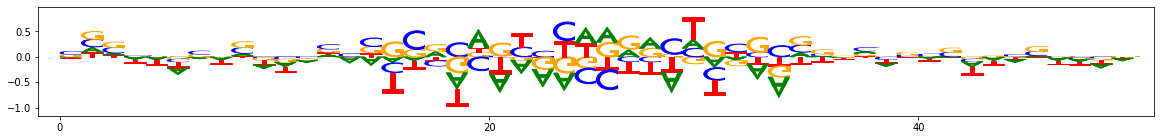

In [19]:
viz_sequence.plot_weights(model.layers[1].get_weights()[0][:,:,0], subticks_frequency=20)
